# Convolutional Autoencoder

## Introduction

讓我們仔細來看一下之前所實作的 Autoencoder 的網路結構，不管它的 `encoder` 還是 `decoder` 都是 `fully connected` 的結構．那就會有一個問題是如果網路的結構換成 `convolutional` 的樣子，是不是同樣可以 work 呢?答案是可以的，也就是今天要來看的 `convolutional autoencoder`．

在 CNN 中，主要有兩個部分一個是 `convolutional layer`，另一個是 `max pooling layer`．在 autoencoder 的 encoder 以及 decoder，fully connected 的結構都是相對應的，例如 encoder 中第一層是 784 維降到 300 維，則相對的在 decoder 中的最後一層就要是 300 維升到 784 維．因此如果在 encoder 的部分有 convolutional layer，則在 decoder 的部分就要有一個 `deconvolutional layer`；在 encoder 的部分有 max pooling layer，則在 decoder 的部分就要有一個 `max unpooling layer`．

### Imports

In [1]:
%matplotlib inline
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from libs.utils import weight_variable, bias_variable
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("MNIST_data/", one_hot = True)
print("Packages loaded")

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Packages loaded


## Deconvolution

那在 encoder 中的 deconvolution 要怎麼做呢，以下有一個簡單的 gif 例子，而在 tensorflow 的實現上已經有了一個 [tf.nn.conv2d_transpose](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard4/tf.nn.conv2d_transpose.md) 來讓我們直接使用．

![](http://imgur.com/J3uW7A7.gif)

這裡會建立一個包含兩層 encoder 以及兩層 decoder 的 convolutional autoencoder 來試試看它重建輸入的能力如何，而這裡的 strides 我們會設定成 2，也就是說對一個 mnist 輸入影像 28 * 28 維，經過 convolutional layer 之後會變成 14 * 14 維．達到維度降低的效果．以下是各層輸出的維度比較．

- x 維度: 28 * 28，channel: 1
- encoder layer1 維度: 14 * 14，channel: 16
- encoder_layer2 維度: 7 * 7，channel: 32
- decoder_layer1 維度: 14 * 14，channel: 16
- decoder_layer2 維度: 28 * 28，channel: 1
- x recontruct = decoder_layer2

(`tf.nn.conv2d_transpose` 的參數跟 tf.nn.conv2d 很像，只是要多一個 `output_shape`)

### Build convolution and deconvolution function

In [2]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 2, 2, 1], padding = 'SAME')

def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 2, 2, 1], padding = 'SAME')

### Build compute graph

In [3]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
x_origin = tf.reshape(x, [-1, 28, 28, 1])

W_e_conv1 = weight_variable([5, 5, 1, 16], "w_e_conv1")
b_e_conv1 = bias_variable([16], "b_e_conv1")
h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, W_e_conv1), b_e_conv1))

W_e_conv2 = weight_variable([5, 5, 16, 32], "w_e_conv2")
b_e_conv2 = bias_variable([32], "b_e_conv2")
h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_conv1, W_e_conv2), b_e_conv2))

code_layer = h_e_conv2
print("code layer shape : %s" % h_e_conv2.get_shape())

W_d_conv1 = weight_variable([5, 5, 16, 32], "w_d_conv1")
b_d_conv1 = bias_variable([1], "b_d_conv1")
output_shape_d_conv1 = tf.pack([tf.shape(x)[0], 14, 14, 16])
h_d_conv1 = tf.nn.relu(deconv2d(h_e_conv2, W_d_conv1, output_shape_d_conv1))

W_d_conv2 = weight_variable([5, 5, 1, 16], "w_d_conv2")
b_d_conv2 = bias_variable([16], "b_d_conv2")
output_shape_d_conv2 = tf.pack([tf.shape(x)[0], 28, 28, 1])
h_d_conv2 = tf.nn.relu(deconv2d(h_d_conv1, W_d_conv2, output_shape_d_conv2))

x_reconstruct = h_d_conv2
print("reconstruct layer shape : %s" % x_reconstruct.get_shape())


code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, ?, ?, ?)


### Build cost function

In [4]:
cost = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

### Training

In [5]:
sess = tf.InteractiveSession()
batch_size = 60
init_op = tf.global_variables_initializer()
sess.run(init_op)

for epoch in range(5000):
    batch = mnist.train.next_batch(batch_size)
    if epoch < 1500:
        if epoch%100 == 0:
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch[0]})))
    else:
        if epoch%1000 == 0: 
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch[0]})))
    optimizer.run(feed_dict={x: batch[0]})
    
print("final loss %g" % cost.eval(feed_dict={x: mnist.test.images}))

step 0, loss 0.103204
step 100, loss 0.0235892
step 200, loss 0.0167378
step 300, loss 0.0203425
step 400, loss 0.0175616
step 500, loss 0.0171841
step 600, loss 0.0155463
step 700, loss 0.0153204
step 800, loss 0.00345139
step 900, loss 0.00248451
step 1000, loss 0.00312759
step 1100, loss 0.00264636
step 1200, loss 0.00225495
step 1300, loss 0.00223552
step 1400, loss 0.00223038
step 2000, loss 0.0017688
step 3000, loss 0.00150994
step 4000, loss 0.00099031
final loss 0.000948159


### Plot reconstructed images

In [6]:
def plot_n_reconstruct(origin_img, reconstruct_img, n = 10):

    plt.figure(figsize=(2 * 10, 4))

    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(origin_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(reconstruct_img[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

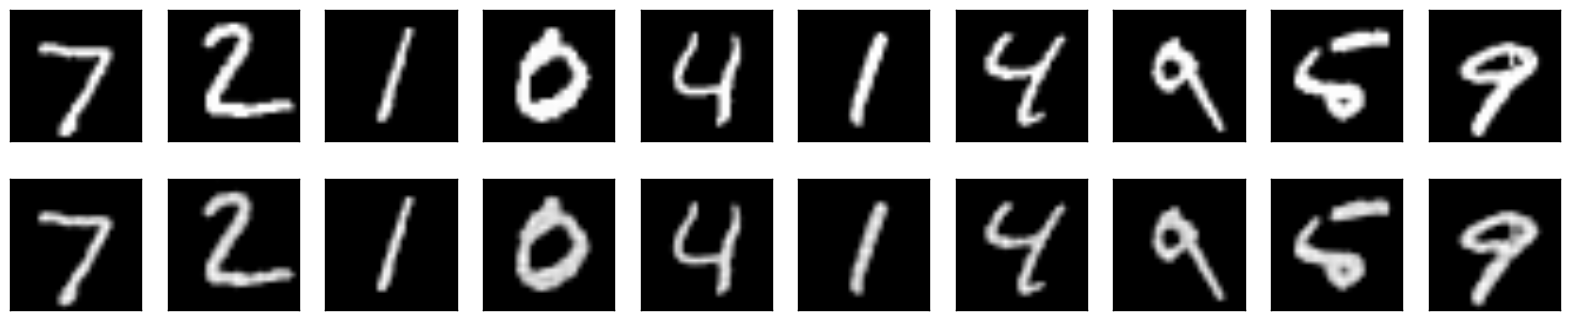

In [7]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img, test_reconstruct_img)

這裡我們可以看到它重建的結果很不錯，尤其 mean square err 都低很多，可見 convolution 實在是滿強大的．接下來我們要輸入一個數字 (7) 看它在 code layer 經過 filter 之後的樣子是如何，這裡印出前 16 個結果．

### Plot code layer result

In [10]:
import math
def plot_conv_layer(layer, image, num_filters):
    output = sess.run(layer, feed_dict = {x: [image]})
    
    num_grids = int(math.ceil(math.sqrt(num_filters)))
    
    fig, axes = plt.subplots(num_grids, num_grids)
    
    for i, ax in enumerate(axes.flat):
        if i < num_grids * num_grids:
            img = output[0, :, :, i]
            ax.imshow(img, interpolation='nearest', cmap='gray')
        
        ax.set_xticks([])
        ax.set_yticks([])
        
    plt.show()

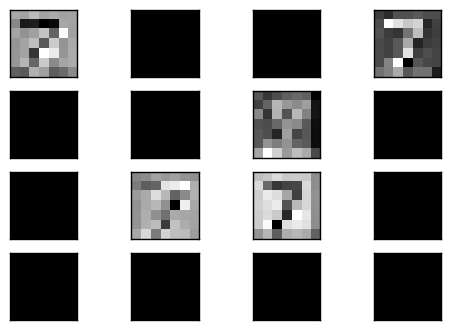

In [9]:
image1 = mnist.test.images[0]
plot_conv_layer(code_layer, image1, 16)

可以看到不是所有的 filter 輸出都有結果，很多都是完全是 0．而有值的輸出，可以隱隱約約看到有數字的形狀．


## Max Unpooling

那在 `Max Unpooling` 要如何實現呢？最簡單的想法是**怎麼來就怎麼回去**，encoder 在做 max pooling 的時候記下取 max 的索引值，而在 unpooling 的時候依據索引回填數值，其他沒有記錄到的地方則為零．

使用 `tf.nn.max_pool_with_argmax` 這個函數，它除了會回傳 pooling 的結果外也會回傳對應原本的索引值 (argmax)，如下．

>The indices in argmax are flattened, so that a maximum value at position [b, y, x, c] becomes flattened index ((b * height + y) * width + x) * channels + c.

理論上在做 unpooling 的時就會用到這裡產生的對應表．不過目前 tensorflow 中沒有 unpooling 這個 op (可以參考 [issue](https://github.com/tensorflow/tensorflow/issues/2169))．因此以下展示了兩種方法作 unpooling 也都不會用到 argmax．

1. 使用 Github Issue 討論中的方法，也就是放大兩倍後在固定的地方填值 (ex. 左上角)

2. 借用影像的 upsample 函數 `tf.image.resize_nearest_neighbor` 來做等比例放大，也就不會補 0．

註: 
- 在 encoder 中都是一個 convolutional layer 接一個 max pooling，因此 convolutional layer 的 strides 就調回為 1，只讓 max pooling 做降維．
- 經過測試以後 encoder 使用 relu；decoder 使用 sigmoid，才有比較好的還原效果，都使用 relu 會訓練失敗．

### Build helper functions

In [45]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')

def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 1, 1, 1], padding = 'SAME')

def max_unpool_2x2(x, output_shape):
    out = tf.concat_v2([x, tf.zeros_like(x)], 3)
    out = tf.concat_v2([out, tf.zeros_like(out)], 2)
    out_size = output_shape
    return tf.reshape(out, out_size)

def max_pool_2x2(x):
    _, argmax = tf.nn.max_pool_with_argmax(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    pool = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    return pool, argmax

### Build compute graph

In [46]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
x_origin = tf.reshape(x, [-1, 28, 28, 1])

W_e_conv1 = weight_variable([5, 5, 1, 16], "w_e_conv1")
b_e_conv1 = bias_variable([16], "b_e_conv1")
h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, W_e_conv1), b_e_conv1))
h_e_pool1, argmax_e_pool1 = max_pool_2x2(h_e_conv1)

W_e_conv2 = weight_variable([5, 5, 16, 32], "w_e_conv2")
b_e_conv2 = bias_variable([32], "b_e_conv2")
h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_pool1, W_e_conv2), b_e_conv2))
h_e_pool2, argmax_e_pool2 = max_pool_2x2(h_e_conv2)

code_layer = h_e_pool2
print("code layer shape : %s" % code_layer.get_shape())

W_d_conv1 = weight_variable([5, 5, 16, 32], "w_d_conv1")
b_d_conv1 = bias_variable([1], "b_d_conv1")

# convolutional layer 不改變輸出的 shape
output_shape_d_conv1 = tf.pack([tf.shape(x)[0], 7, 7, 16])
h_d_conv1 = tf.nn.sigmoid(deconv2d(code_layer, W_d_conv1, output_shape_d_conv1))

# max unpool layer 改變輸出的 shape 為兩倍
output_shape_d_pool1 = tf.pack([tf.shape(x)[0], 14, 14, 16])
h_d_pool1 = max_unpool_2x2(h_d_conv1, output_shape_d_pool1)

W_d_conv2 = weight_variable([5, 5, 1, 16], "w_d_conv2")
b_d_conv2 = bias_variable([16], "b_d_conv2")

# convolutional layer 不改變輸出的 shape
output_shape_d_conv2 = tf.pack([tf.shape(x)[0], 14, 14, 1])
h_d_conv2 = tf.nn.sigmoid(deconv2d(h_d_pool1, W_d_conv2, output_shape_d_conv2))

# max unpool layer 改變輸出的 shape 為兩倍
output_shape_d_pool2 = tf.pack([tf.shape(x)[0], 28, 28, 1])
h_d_pool2 = max_unpool_2x2(h_d_conv2, output_shape_d_pool2)

x_reconstruct = h_d_pool2
print("reconstruct layer shape : %s" % x_reconstruct.get_shape())

code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, 28, 28, 1)


### Build cost function

In [47]:
cost = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

### Training

In [48]:
sess = tf.InteractiveSession()
batch_size = 60
init_op = tf.global_variables_initializer()
sess.run(init_op)

for epoch in range(5000):
    batch = mnist.train.next_batch(batch_size)
    if epoch < 1500:
        if epoch%100 == 0:
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch[0]})))
    else:
        if epoch%1000 == 0: 
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch[0]})))
    optimizer.run(feed_dict={x: batch[0]})
    
print("final loss %g" % cost.eval(feed_dict={x: mnist.test.images}))

step 0, loss 0.143627
step 100, loss 0.0930532
step 200, loss 0.0884409
step 300, loss 0.0928427
step 400, loss 0.0909152
step 500, loss 0.0826991
step 600, loss 0.0848275
step 700, loss 0.0810827
step 800, loss 0.0864824
step 900, loss 0.086182
step 1000, loss 0.0865941
step 1100, loss 0.0828469
step 1200, loss 0.091879
step 1300, loss 0.0909268
step 1400, loss 0.0917193
step 2000, loss 0.0869293
step 3000, loss 0.078727
step 4000, loss 0.0829563
final loss 0.0858374


### Plot recontructed images

可以看到重建的影像有成功，但是有點狀的稀疏情形，因為在經過 unpooling 的時候使採取補 0 的動作．

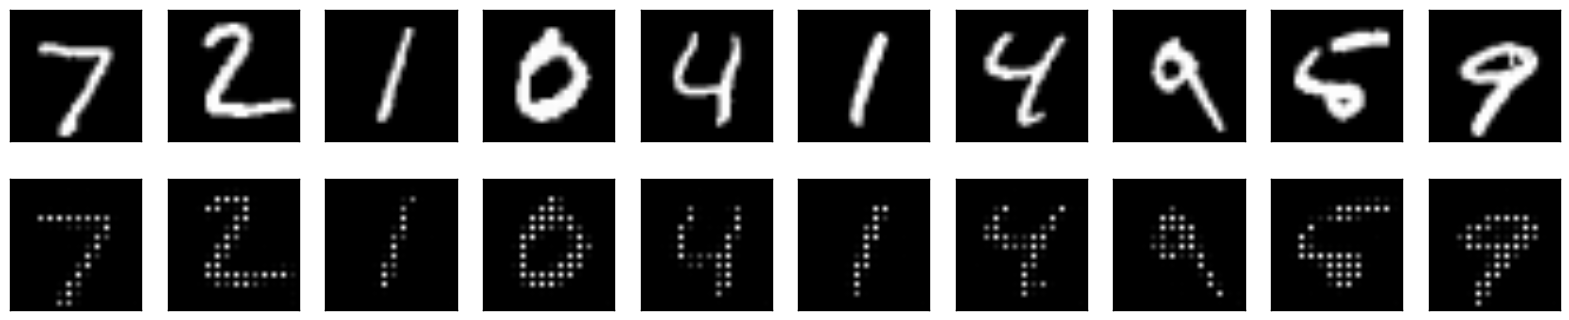

In [49]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img, test_reconstruct_img)

### Plot code layer result

而在 code layer 中會發現也是部分的 filter 有值，另外許多部分都為 0．

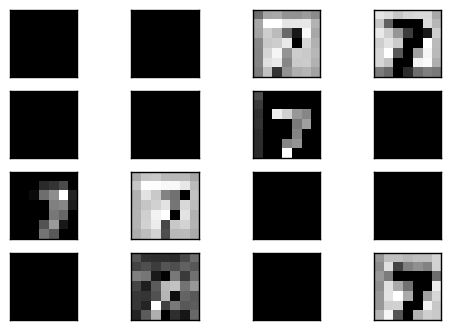

In [52]:
image1 = mnist.test.images[0]
plot_conv_layer(code_layer, image1, 16)

接下來觀察 deconvolution 1 的輸出，以及經過 unpooling 後的 pool 1 輸出，會很明顯地看到 unpooling 輸出有等比例放大，但是會有稀疏的情形，這就是因為補 0 的緣故．

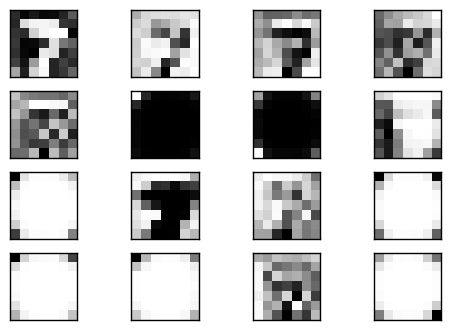

In [50]:
image1 = mnist.test.images[0]
plot_conv_layer(h_d_conv1, image1, 16)

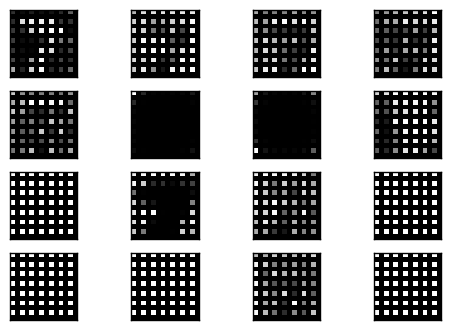

In [51]:
image1 = mnist.test.images[0]
plot_conv_layer(h_d_pool1, image1, 16)

接下來使用 `tf.image.resize_nearest_neighbor` 的方法來做還原

### Build helper functions

In [11]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding = 'SAME')

def deconv2d(x, W, output_shape):
    return tf.nn.conv2d_transpose(x, W, output_shape, strides = [1, 1, 1, 1], padding = 'SAME')

def max_pool_2x2(x):
    _, argmax = tf.nn.max_pool_with_argmax(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding = 'SAME')
    pool = tf.nn.max_pool(x, ksize = [1, 2, 2, 1], strides = [1, 2, 2, 1], padding = 'SAME')
    return pool, argmax

def max_unpool_2x2(x, shape):
    inference = tf.image.resize_nearest_neighbor(x, tf.pack([shape[1]*2, shape[2]*2]))
    return inference

### Build compute graph

In [12]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, shape = [None, 784])
x_origin = tf.reshape(x, [-1, 28, 28, 1])

W_e_conv1 = weight_variable([5, 5, 1, 16], "w_e_conv1")
b_e_conv1 = bias_variable([16], "b_e_conv1")
h_e_conv1 = tf.nn.relu(tf.add(conv2d(x_origin, W_e_conv1), b_e_conv1))
h_e_pool1, argmax_e_pool1 = max_pool_2x2(h_e_conv1)

W_e_conv2 = weight_variable([5, 5, 16, 32], "w_e_conv2")
b_e_conv2 = bias_variable([32], "b_e_conv2")
h_e_conv2 = tf.nn.relu(tf.add(conv2d(h_e_pool1, W_e_conv2), b_e_conv2))
h_e_pool2, argmax_e_pool2 = max_pool_2x2(h_e_conv2)

code_layer = h_e_pool2
print("code layer shape : %s" % code_layer.get_shape())

W_d_conv1 = weight_variable([5, 5, 16, 32], "w_d_conv1")
b_d_conv1 = bias_variable([1], "b_d_conv1")

# convolutional layer 不改變輸出的 shape
output_shape_d_conv1 = tf.pack([tf.shape(x)[0], 7, 7, 16])
h_d_conv1 = tf.nn.sigmoid(deconv2d(code_layer, W_d_conv1, output_shape_d_conv1))

# max unpool layer 改變輸出的 shape 為兩倍
h_d_pool1 = max_unpool_2x2(h_d_conv1, [-1, 7, 7, 16])

W_d_conv2 = weight_variable([5, 5, 1, 16], "w_d_conv2")
b_d_conv2 = bias_variable([16], "b_d_conv2")

# convolutional layer 不改變輸出的 shape
output_shape_d_conv2 = tf.pack([tf.shape(x)[0], 14, 14, 1])
h_d_conv2 = tf.nn.sigmoid(deconv2d(h_d_pool1, W_d_conv2, output_shape_d_conv2))

# max unpool layer 改變輸出的 shape 為兩倍
h_d_pool2 = max_unpool_2x2(h_d_conv2, [-1, 14, 14, 1])

x_reconstruct = h_d_pool2
print("reconstruct layer shape : %s" % x_reconstruct.get_shape())

code layer shape : (?, 7, 7, 32)
reconstruct layer shape : (?, 28, 28, ?)


### Build cost function

In [13]:
cost = tf.reduce_mean(tf.pow(x_reconstruct - x_origin, 2))
optimizer = tf.train.AdamOptimizer(0.01).minimize(cost)

### Training

In [14]:
sess = tf.InteractiveSession()
batch_size = 60
init_op = tf.global_variables_initializer()
sess.run(init_op)

for epoch in range(5000):
    batch = mnist.train.next_batch(batch_size)
    if epoch < 1500:
        if epoch%100 == 0:
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch[0]})))
    else:
        if epoch%1000 == 0: 
            print("step %d, loss %g"%(epoch, cost.eval(feed_dict={x:batch[0]})))
    optimizer.run(feed_dict={x: batch[0]})
    
print("final loss %g" % cost.eval(feed_dict={x: mnist.test.images}))

step 0, loss 0.117823
step 100, loss 0.022254
step 200, loss 0.0202093
step 300, loss 0.0189887
step 400, loss 0.0180246
step 500, loss 0.0189967
step 600, loss 0.0178063
step 700, loss 0.0176837
step 800, loss 0.0180569
step 900, loss 0.0173936
step 1000, loss 0.0176715
step 1100, loss 0.0180319
step 1200, loss 0.0170217
step 1300, loss 0.0181365
step 1400, loss 0.0164201
step 2000, loss 0.0178452
step 3000, loss 0.0171906
step 4000, loss 0.0164161
final loss 0.0172661


### Plot reconstructed images

Bingo!可以看到效果算不錯的重建影像，而且不會有前一種方法的稀疏情形．

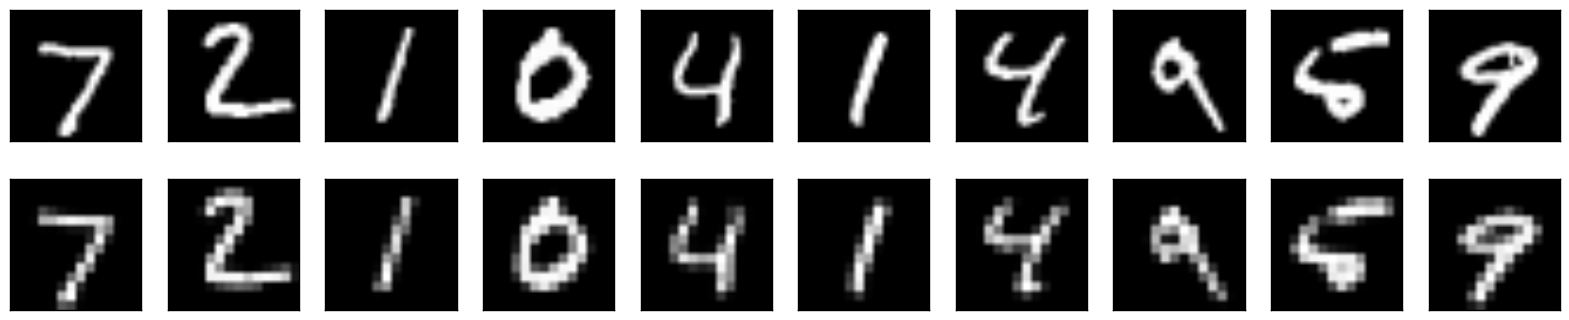

In [15]:
test_size = 10
test_origin_img = mnist.test.images[0:test_size, :]
test_reconstruct_img = np.reshape(x_reconstruct.eval(feed_dict = {x: test_origin_img}), [-1, 28 * 28])
plot_n_reconstruct(test_origin_img, test_reconstruct_img)

### Plot code layer result

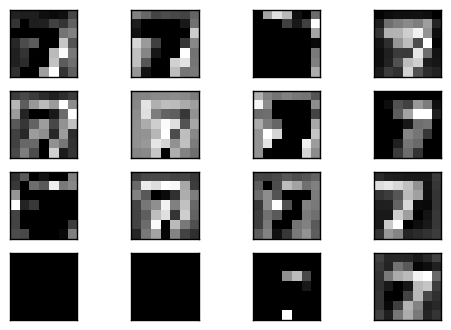

In [16]:
image1 = mnist.test.images[0]
plot_conv_layer(code_layer, image1, 16)

可以看到 convolutional layer 的輸出在 unpooling 中被很平滑的放大兩倍．

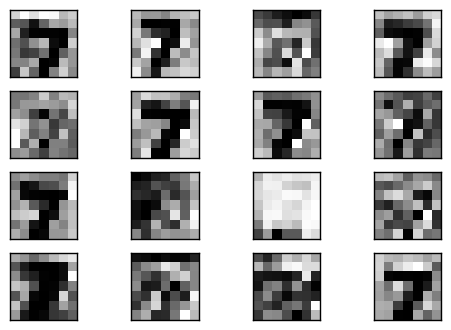

In [17]:
image1 = mnist.test.images[0]
plot_conv_layer(h_d_conv1, image1, 16)

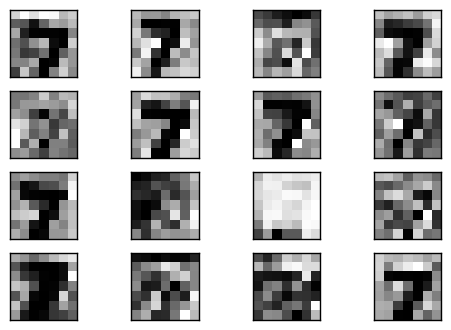

In [18]:
image1 = mnist.test.images[0]
plot_conv_layer(h_d_pool1, image1, 16)

## 小結

這裡實現了 convolutional autoencoder，包含使用了 `deconvolution` 以及 `max unpooling` 兩個方法來組成 decoder．其中 deconvolution 使用了官方的 op，而 max unpooling 則使用了兩種非官方的方法，其中用 tf.image.resize_nearest_neighbor 的方法所做的 unpooling 效果較好．

遇到最困難的點會是一開始在 decoder 都使用 relu 作 activation function，但是完全得不出好的重建影像，而後來改用 sigmoid 後才成功．我想是因為 relu 會讓小於 0 的部分都等於 0，失去了影響後面網路的能力．或許在更大且複雜的網路，或是較長的訓練時間，才有可能成功．

### 問題

- conv2d_transpose 是如何利用 padding 調整輸出大小的呢?
- convolutional autoencoder 和 autoencoder mean square error 似乎低很多，why?

## 學習資源連結

- [github convolutional autoencoder example](https://github.com/pkmital/tensorflow_tutorials/blob/master/python/09_convolutional_autoencoder.py)
- [tensorflow conv2d_transpose doc](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard4/tf.nn.conv2d_transpose.md)
- [tensorflow max pool with argmax doc](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/g3doc/api_docs/python/functions_and_classes/shard9/tf.nn.max_pool_with_argmax.md)
- [max unpool implement](https://github.com/fabianbormann/Tensorflow-DeconvNet-Segmentation/blob/master/tests/UnpoolLayerTest.ipynb)